In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import qiskit
import numpy as np

from PatchedMeasCal.tensor_patch_cal import TensorPatchFitter
from PatchedMeasCal.inv_measure_methods import aim, sim
from PatchedMeasCal.jigsaw import jigsaw
from PatchedMeasCal.qiskit_meas_fitters import qiskit_full, qiskit_linear


from PatchedMeasCal.fake_backends import LocalSimulator


from PatchedMeasCal import state_prep_circuits
from PatchedMeasCal.fake_measurement_distributions import renormalise_measurement_results
from PatchedMeasCal.utils import Progressbar

from PatchedMeasCal.fake_backends import Grid, Hexagonal16, FullyConnected

from PatchedMeasCal.state_prep_circuits import GHZ_prep, GHZ_state_dist
from PatchedMeasCal.bv import bv_circuit_cmap

from PatchedMeasCal import non_standard_coupling_maps


from qiskit import Aer, execute, QuantumCircuit
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

from functools import partial

import qiskit.tools.jupyter

import mthree

import random

qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider()

%qiskit_job_watcher

ibmqfactory.load_account:WARNING:2023-03-02 02:51:54,264: Credentials are already in use. The existing account in the session will be replaced.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

## Setup
The idea here is that each approachs gets a maximum of 32000 measurement shots to spend
- Backend style methods will spend 50% of that on the build, 50% of that on the run
- Circuit style methods will spend 50% on their full run, and the other 50% on other circuits that need to be exectued
- AIM will divide theirs up evenly

In [2]:
n_qubits = 6
n_meas_shots = 16000
n_build_shots = 16000
n_shots_qiskit_full = n_build_shots // (2 ** n_qubits) 
n_shots_qiskit_partial = n_build_shots // (n_qubits)


n_circuit_method_shots = n_meas_shots + n_build_shots
backend = Grid(2, 3) #LocalSimulator(n_qubits) #provider.get_backend('ibmq_lima')
n_qubits = 6

circuit = GHZ_prep(backend)

n_shots_cmc = n_build_shots // (2 * len(backend.configuration().coupling_map))

#err_cmap = [[1, 4], [2, 4], [3, 4], [0, 3], [0, 4]]
err_cmap = [[1, 4], [2, 4], [3, 4], [0, 3], [0, 4], [4, 5]]

## Mitigation Methods Build

In [3]:
full_filter = qiskit_full(backend, n_qubits, n_shots_qiskit_full)

# n Circuits to execute
linear_filter = qiskit_linear(backend, n_qubits, n_shots_qiskit_partial)

mit = mthree.M3Mitigation(backend)
mit.cals_from_system(list(range(n_qubits)), n_build_shots // 2)

tpf_err = TensorPatchFitter(backend, n_shots=n_shots_cmc, coupling_map=err_cmap)
tpf_err.build(verbose=True)

tpf = TensorPatchFitter(backend, n_shots=n_shots_cmc)
tpf.build(verbose=True)

Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results 

## Run with repetitions
If everything above is working, let's crank it out a few times

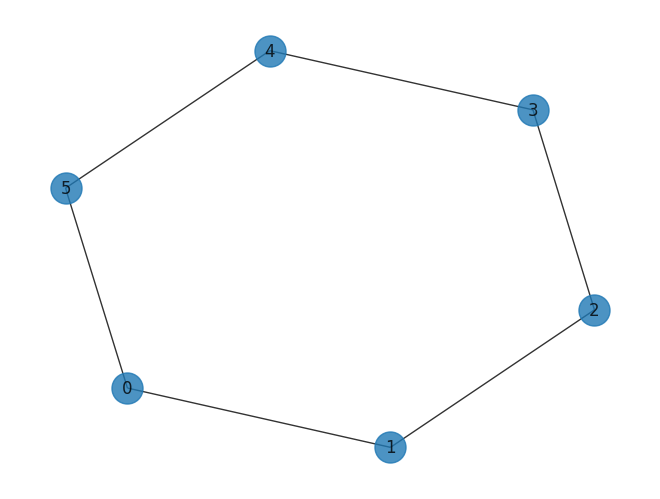

In [4]:
G = nx.Graph()
G.add_nodes_from(list(range(n_qubits)))
G.add_edges_from([(i, (i + 1) % n_qubits) for i in list(range(n_qubits))])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

Qiskit QAOA Code

In [8]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, *args, **kwargs):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """    
    def execute_circ(theta, *args, backend=None, mitigation=None, execution=None, **kwargs):
        qc = create_qaoa_circ(G, theta)
        if execution is None:
            counts = backend.run(qc, *args, **kwargs).result().get_counts()
        else:
            counts = execution(qc, *args, **kwargs)
            
        if mitigation is not None:
            counts = mitigation(counts, *args, **kwargs)
        
        return compute_expectation(counts, G)
    
    return partial(execute_circ, *args, **kwargs)

In [16]:
def calc_target_val(G):
    target_val = 0
    n_trials = 1000
    expectation = get_expectation(G, backend=LocalSimulator(n_qubits))
    for i in range(n_trials):
        target_val += expectation([1.0, 1.0])
    target_val /= n_trials
    return target_val

def distance_measure_base(x, target_val):
    return abs(x - target_val)
dist_measure = lambda x: distance_measure_base(x, target_val)

In [33]:
n_reps = 10

circuit_res = []
aim_res = []
sim_res = []
full_res = []
lin_res = []
tpf_res = []
tpf_e_res = []
jr_res = []
m3_res = []

backend_generators = [
#     partial(Grid, 2, 2), # 4
#     partial(Grid, 3, 2), # 6
#     partial(Grid, 4, 2), # 8
#     partial(Grid, 3, 3), # 9
#     partial(Grid, 5, 2), # 10
#     partial(Grid, 6, 2), # 12
    partial(Grid, 7, 2), # 14
    partial(Grid, 5, 3), # 15
    partial(Grid, 4, 4)  # 16
]

for backend_gen in backend_generators:

    circuit_round = []
    aim_round = []
    sim_round = []
    tpf_round = []
    tpf_e_round = []
    jr_round = []
    m3_round = []
    linear_round = []
    full_round = []

    n_qubits = len(backend_gen().properties().qubits)
    sim_backend = LocalSimulator(n_qubits)
    G = nx.Graph()
    G.add_nodes_from(list(range(n_qubits)))
    G.add_edges_from([(i, (i + 1) % n_qubits) for i in list(range(n_qubits))])
    target_val = calc_target_val(G)
    dist_measure = lambda x: distance_measure_base(x, target_val)
    
    for _ in range(n_reps):
        backend = backend_gen()
        err_cmap = non_standard_coupling_maps.error_coupling_map(backend=backend)
        
        aim_l = lambda circ: aim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
        sim_l = lambda circ: sim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
        jigsaw_l = lambda circ: jigsaw(circ, backend, n_circuit_method_shots, equal_shot_distribution=True)

#         full_filter = qiskit_full(backend, n_qubits, n_shots_qiskit_full)

#         # n Circuits to execute
#         linear_filter = qiskit_linear(backend, n_qubits, n_shots_qiskit_partial)

        mit = mthree.M3Mitigation(backend)
        mit.cals_from_system(list(range(n_qubits)), n_build_shots // 2)

        tpf_err = TensorPatchFitter(backend, n_shots=n_shots_cmc, coupling_map=err_cmap)
        tpf_err.build(verbose=True)

        tpf = TensorPatchFitter(backend, n_shots=n_shots_cmc)
        tpf.build(verbose=True)

        mit_apply = lambda x: mit.apply_correction(x, list(range(n_qubits))).nearest_probability_distribution()

        
        expectation = get_expectation(G, backend=backend)
        res = expectation([1.0, 1.0]) 
        circuit_round.append(
            dist_measure(res)
        )

#         expectation = get_expectation(G, backend=backend, mitigation=full_filter.apply)
#         res = expectation([1.0, 1.0]) 
#         full_round.append(
#             dist_measure(res)
#         )

#         expectation = get_expectation(G, backend=backend, mitigation=linear_filter.apply)
#         res = expectation([1.0, 1.0]) 
#         linear_round.append(
#             dist_measure(res)
#         )

        expectation = get_expectation(G, backend=backend, mitigation=tpf.apply)
        res = expectation([1.0, 1.0]) 
        tpf_round.append(
            dist_measure(res)
        )

        expectation = get_expectation(G, backend=backend, mitigation=tpf_err.apply)
        res = expectation([1.0, 1.0]) 
        tpf_e_round.append(
            dist_measure(res)
        )


        expectation = get_expectation(G, backend=backend, mitigation=mit_apply)
        res = expectation([1.0, 1.0]) 
        m3_round.append(
            dist_measure(res)
        )

        expectation = get_expectation(G, backend=backend, execution=sim_l)
        res = expectation([1.0, 1.0]) 
        sim_round.append(
            dist_measure(res)
        )

        expectation = get_expectation(G, backend=backend, execution=aim_l)
        res = expectation([1.0, 1.0]) 
        aim_round.append(
            dist_measure(res)
        )

        expectation = get_expectation(G, backend=backend, execution=jigsaw_l)
        res = expectation([1.0, 1.0]) 
        jr_round.append(
            dist_measure(res)
        )
        print("Round Complete")
        
    circuit_res.append(circuit_round)
    aim_res.append(aim_round)
    sim_res.append(sim_round)
    full_res.append(full_round)
    lin_res.append(linear_round)
    tpf_res.append(tpf_round)
    tpf_e_res.append(tpf_e_round)
    jr_res.append(jr_round)
    m3_res.append(m3_round)
    
results = {
'bare':circuit_res,
'aim':aim_res,
'sim':sim_res,
'full':full_res,
'lin':lin_res,
'cmc':tpf_res,
'cmc_err':tpf_e_res,
'jig':jr_res,
'm3':m3_res
}


Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results 

	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Round Complete
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [=====

	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Round Complete
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%

	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================

	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Round Complete
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%

	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Round Complete
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits
	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibration

KeyboardInterrupt: 

In [35]:
results = {
'bare':circuit_res,
'aim':aim_res,
'sim':sim_res,
'full':full_res,
'lin':lin_res,
'cmc':tpf_res,
'cmc_err':tpf_e_res,
'jig':jr_res,
'm3':m3_res
}


In [36]:
results

{'bare': [[0.2632812499999999,
   0.2574218749999999,
   0.2828124999999999,
   0.2593749999999999,
   0.2769531249999999,
   0.2671874999999999,
   0.1832031249999999,
   0.1792968749999999,
   0.2808593749999999,
   0.3824218749999999],
  [0.22142382812499983,
   0.32103320312499983,
   0.33470507812499983,
   0.25462695312499983,
   0.47337695312499983,
   0.22337695312499983,
   0.29564257812499983,
   0.28197070312499983,
   0.34056445312499983,
   0.31517382812499983],
  [0.37972656250000014,
   0.29574218750000014,
   0.31917968750000014,
   0.24886718750000014,
   0.31527343750000014,
   0.34261718750000014,
   0.36996093750000014,
   0.34066406250000014,
   0.31136718750000014,
   0.40902343750000014]],
 'aim': [[0.4219218749999998,
   0.42550520833333305,
   0.42208854166666665,
   0.471171875,
   0.4270052083333331,
   0.43542187499999985,
   0.4734218750000001,
   0.4029218750000001,
   0.427921875,
   0.4395052083333333],
  [0.3880748697916667,
   0.38299153645833295,
   0

In [204]:
results_4_8 = {'bare': [[0.10290820312499993,
   0.08728320312499993,
   0.10486132812499993,
   0.16345507812499993,
   0.07751757812499993,
   0.19275195312499993,
   0.10681445312499993,
   0.06970507812499993,
   0.03650195312499993,
   0.01111132812499993],
  [0.14003710937500014,
   0.13613085937500014,
   0.22011523437500014,
   0.23378710937500014,
   0.09511523437500014,
   0.16738085937500014,
   0.16152148437500014,
   0.13417773437500014,
   0.14394335937500014,
   0.18886523437500014],
  [0.2828164062499998,
   0.20273828124999982,
   0.17734765624999982,
   0.22031640624999982,
   0.15586328124999982,
   0.14805078124999982,
   0.15000390624999982,
   0.24180078124999982,
   0.23789453124999982,
   0.20273828124999982]],
 'aim': [[0.17249153645833326,
   0.11790820312499983,
   0.13649153645833323,
   0.14457486979166667,
   0.13032486979166658,
   0.18107486979166665,
   0.1210748697916666,
   0.13982486979166664,
   0.135658203125,
   0.14465820312499988],
  [0.23603710937500022,
   0.24745377604166663,
   0.2040371093750002,
   0.2582037760416669,
   0.19553710937500002,
   0.22587044270833356,
   0.21662044270833336,
   0.2632871093750002,
   0.2330371093750001,
   0.22387044270833334],
  [0.32476432291666635,
   0.3122643229166666,
   0.29318098958333305,
   0.26918098958333303,
   0.3062643229166664,
   0.27959765625,
   0.2976809895833332,
   0.29701432291666663,
   0.31543098958333315,
   0.2766809895833333]],
 'sim': [[0.165470703125,
   0.1314082031249999,
   0.1334082031249999,
   0.14109570312499997,
   0.14534570312499984,
   0.17315820312499985,
   0.10897070312500001,
   0.14378320312499993,
   0.13490820312499996,
   0.1490332031249999],
  [0.234224609375,
   0.241662109375,
   0.20947460937499995,
   0.24134960937500027,
   0.20209960937500027,
   0.2202246093750002,
   0.20816210937500035,
   0.2510996093750002,
   0.22859960937500023,
   0.25216210937499994],
  [0.30747265624999986,
   0.30447265624999975,
   0.29922265625,
   0.25497265624999965,
   0.2975976562499998,
   0.26909765625000004,
   0.28359765625,
   0.3071601562499997,
   0.3147851562499997,
   0.26859765624999987]],
 'full': [[0.015268758839700025,
   0.005168933450613533,
   0.03842040057565277,
   0.012535782568600773,
   0.05458032926186984,
   0.03527398639112955,
   0.06555653017144825,
   0.0010879692113161532,
   0.005318659315707741,
   0.008271594594326581],
  [0.015978389573779506,
   0.023428806050686646,
   0.04747935066246223,
   0.13293162767145672,
   0.13220611464132004,
   0.059852898203593075,
   0.043536273711076046,
   0.005270064934610907,
   0.07368922247120757,
   0.04351748841226799],
  [0.005959751536373403,
   0.02687838482109406,
   0.06159828064898232,
   0.022463002334521143,
   0.0441085310756657,
   0.031909803712905305,
   0.11027026358441683,
   0.0017146433850876441,
   0.07068670028318236,
   0.045862929062705504]],
 'lin': [[0.01023986595187032,
   0.02227105471967805,
   0.02685149201013326,
   0.041097216486784216,
   0.0005786248618180334,
   0.010051897942112253,
   0.03305758298518646,
   0.012418203146144391,
   0.05689261062917916,
   0.03241672507001869],
  [0.07528774915440817,
   0.0503507688436331,
   0.09006037532323052,
   0.02905476414142072,
   0.042258549914215404,
   0.09022300388480842,
   0.041354064027077975,
   0.02504728826615432,
   0.09368100763297216,
   0.07076396290144116],
  [0.060940543856591756,
   0.003416443301927252,
   0.022384762743068887,
   0.04102242473931339,
   0.018037152068739015,
   0.09919325382817146,
   0.012116344462948625,
   0.04562460845416583,
   0.018397250586958958,
   0.06855245508207286]],
 'cmc': [[0.010844594507089633,
   0.017038825504440913,
   0.0407066195178063,
   0.03289455358606963,
   0.06451589336914276,
   0.035955806389795786,
   0.000265072566620006,
   0.002784579615279892,
   0.08453530351012328,
   0.01711449801934961],
  [0.02573718186482976,
   0.10549068032033926,
   0.06294726015758956,
   0.009391199423300467,
   0.0585694503165044,
   0.08875884649095411,
   0.11905997679653435,
   0.014054367004659785,
   0.06398692725516142,
   0.05061478180111978],
  [0.16273461209514029,
   0.17505874779474873,
   0.049084936376714516,
   0.10236402131278943,
   0.0757686851350523,
   0.001685327492191302,
   0.03684848320140155,
   0.0018298941073351394,
   0.0422700720048117,
   0.024610773768151795]],
 'cmc_err': [[0.04613213494092938,
   0.04805823599930803,
   0.022432626556861512,
   0.008484809164231333,
   0.07183118726729454,
   0.04230606137003057,
   0.009424062324404847,
   0.02804858039543645,
   0.01272124673573849,
   0.004426605540049033],
  [0.029058540769956398,
   0.008951062415662125,
   0.1275381669914082,
   0.041550281590556626,
   0.004495558584786785,
   0.03471043474939162,
   0.11560170273643733,
   0.004904781852802298,
   0.07239136600350227,
   0.04269428810978315],
  [0.057841520797985435,
   0.003033234560806619,
   0.08908256566797901,
   0.036350808314871585,
   0.11229250785607148,
   0.04636561665137284,
   0.025482072148686363,
   0.00832572504077378,
   0.17851151042064828,
   0.06240981771288023]],
 'jig': [[0.1408757160102947,
   0.016173200414623556,
   0.030583202906480977,
   0.05974088874558281,
   0.04530231703591947,
   0.1954149058193828,
   0.04703680515559672,
   0.12056528790021392,
   0.09834558562245288,
   0.12011126106152603],
  [0.17208060385516744,
   0.3001355100726264,
   0.46732018162245037,
   0.22530399433708403,
   0.19218732851180453,
   0.2797527431634559,
   0.2795473544063172,
   0.29658321392707565,
   0.35992852769956496,
   0.2597046238951033],
  [0.4213277813525482,
   0.5219616801759832,
   0.43834467177770264,
   0.3705731201088587,
   0.31470894409205386,
   0.3463329780910147,
   0.4020677664693353,
   0.26596297562927607,
   0.5018017353017705,
   0.4119970924422871]],
 'm3': [[0.01632823293487351,
   0.003047941062295667,
   0.08304154217589232,
   0.11484495343984791,
   0.04327452096640583,
   0.06934148779749849,
   0.06955819336551494,
   0.0532229343860271,
   0.08498467435524737,
   0.04425667733727501],
  [0.07033038979767747,
   0.14883547054199164,
   0.10194701277372786,
   0.039457865036156115,
   0.03199722604953115,
   0.018851097129438,
   0.0073723677771435625,
   0.1241126498368561,
   0.020927373911421743,
   0.08251990285010091],
  [0.07477803173020092,
   0.14972577375246532,
   0.017127524832253105,
   0.011444748218353062,
   0.08319485639778179,
   0.06670254508122353,
   0.06116210316527626,
   0.05684567647703398,
   0.01171475066800598,
   0.08101287517798017]]}

{'bare': [0.1744140624999999, 0.1666015624999999, 0.2876953124999999],
 'full': [0.03715662836587219, 0.04511496700361306, 0.05541842943499864],
 'linear': [0.08064431829270324, 0.05210880354486269, 0.07298521465944585],
 'aim': [0.2363880208333331, 0.22263802083333317, 0.22780468749999994],
 'sim': [0.23980468749999995, 0.22055468749999996, 0.22242968750000003],
 'jigsaw': [0.2046028353145215, 0.15477712278576927, 0.36462765665579955],
 'cmc': [0.020056928743120928, 0.05525442442881223, 0.0071582838027071105],
 'cmc_err': [0.09952657911305973, 0.0044355904587636275, 0.07773018344102534],
 'm3': [0.083263160321144, 0.14967324010877503, 0.0984623968061924]}

In [9]:
results_9_12 = {'bare': [[0.2632812499999999,
   0.2574218749999999,
   0.2828124999999999,
   0.2593749999999999,
   0.2769531249999999,
   0.2671874999999999,
   0.1832031249999999,
   0.1792968749999999,
   0.2808593749999999,
   0.3824218749999999],
  [0.22142382812499983,
   0.32103320312499983,
   0.33470507812499983,
   0.25462695312499983,
   0.47337695312499983,
   0.22337695312499983,
   0.29564257812499983,
   0.28197070312499983,
   0.34056445312499983,
   0.31517382812499983],
  [0.37972656250000014,
   0.29574218750000014,
   0.31917968750000014,
   0.24886718750000014,
   0.31527343750000014,
   0.34261718750000014,
   0.36996093750000014,
   0.34066406250000014,
   0.31136718750000014,
   0.40902343750000014]],
 'aim': [[0.4219218749999998,
   0.42550520833333305,
   0.42208854166666665,
   0.471171875,
   0.4270052083333331,
   0.43542187499999985,
   0.4734218750000001,
   0.4029218750000001,
   0.427921875,
   0.4395052083333333],
  [0.3880748697916667,
   0.38299153645833295,
   0.3834082031249997,
   0.3575748697916663,
   0.41790820312499966,
   0.333241536458333,
   0.3661582031249999,
   0.3779082031249996,
   0.4034082031249997,
   0.35857486979166664],
  [0.4931171875000002,
   0.44570052083333334,
   0.4407838541666669,
   0.4317005208333331,
   0.4478671875,
   0.4385338541666668,
   0.4428671875000001,
   0.48611718750000055,
   0.4243671875000006,
   0.47795052083333367]],
 'sim': [[0.4559843749999999,
   0.41579687499999984,
   0.4383593750000001,
   0.434984375,
   0.43004687499999994,
   0.4174843749999999,
   0.4427343750000001,
   0.42504687500000005,
   0.3908593749999998,
   0.44948437499999994],
  [0.37784570312499977,
   0.38065820312499987,
   0.380408203125,
   0.3421582031249999,
   0.4195957031249997,
   0.32922070312499985,
   0.37509570312499996,
   0.3704082031249998,
   0.40490820312499975,
   0.3635332031249998],
  [0.4669921874999998,
   0.4426796875000001,
   0.44749218749999997,
   0.4114921875000004,
   0.44417968750000014,
   0.45524218750000056,
   0.45792968750000007,
   0.4635546875000003,
   0.4351171875000004,
   0.47086718750000056]],
 'full': [[], [], []],
 'lin': [[], [], []],
 'cmc': [[0.17103264025748732,
   0.19839972929218108,
   0.180965266635706,
   0.1402101876702062,
   0.21248581259460586,
   0.2573802683494164,
   0.10335907100907749,
   0.11999132730646966,
   0.1439497770014051,
   0.21226606222398425],
  [0.27349149011349283,
   0.2729408902635453,
   0.31878591110260324,
   0.29595745328286016,
   0.36646954319984726,
   0.15436427531209018,
   0.35741419384284034,
   0.20395244860686113,
   0.3516916782305324,
   0.18100871046256684],
  [0.5327488695190272,
   0.38607354839213404,
   0.39859830759768755,
   0.3319190880721852,
   0.3740753171021618,
   0.36916518508450125,
   0.3644328992435959,
   0.4039225505050874,
   0.43894657021314565,
   0.44042355803911626]],
 'cmc_err': [[0.1966162499085633,
   0.13584111792087494,
   0.14180054091707506,
   0.24509727408536364,
   0.12919716061969133,
   0.21036424545640742,
   0.14957057540877017,
   0.04547814239707204,
   0.18116019937935368,
   0.13320918950202332],
  [0.37095989245503747,
   0.27635594998358837,
   0.24662098427263546,
   0.19893117748313438,
   0.2960729848658912,
   0.27961954481231244,
   0.23926450564398039,
   0.33772782294098835,
   0.32923429899338563,
   0.1473550158536301],
  [0.4613673977164199,
   0.41860129532639334,
   0.4012574567562952,
   0.31043372829614757,
   0.47600866798916286,
   0.46692801954740304,
   0.475978087989934,
   0.4270943164545278,
   0.3599463850617406,
   0.5279135773778378]],
 'jig': [[0.427244999930541,
   0.4113093121124347,
   0.414650505818404,
   0.5199903754275623,
   0.381391302417299,
   0.5176343864596986,
   0.6375790738874918,
   0.4570087776159988,
   0.6769077547993589,
   0.5097100661269138],
  [0.7301610947441515,
   0.5127992621705117,
   0.44227929440927616,
   0.5135562299469751,
   0.6677343571649401,
   0.5477916151516271,
   0.39007649032817326,
   0.41627498358879444,
   0.5603573981656234,
   0.6854822042752473],
  [0.8397919204676736,
   0.6164280505925666,
   0.5148111888831854,
   0.46705177465327186,
   0.7416283997023969,
   0.5993442210944782,
   0.8476392832976414,
   0.8300849493257214,
   0.7269996902898974,
   0.6071987395837546]],
 'm3': [[0.044394744417903365,
   0.06710867727512593,
   0.12438014623063243,
   0.11309659921819026,
   0.1320594523354579,
   0.09847740078787437,
   0.04309416088612483,
   0.02021112761540067,
   0.08402394544341218,
   0.03566587308282898],
  [0.06639604721912074,
   0.19515395894562948,
   0.24449331811588015,
   0.17636174280504102,
   0.1660996482598036,
   0.07985126664425657,
   0.20549536505236876,
   0.1626334060256971,
   0.1771660125041863,
   0.15973273027525048],
  [0.3767991933077841,
   0.3408046990052158,
   0.20065381054055909,
   0.3136511821947554,
   0.29454194704048753,
   0.34238511778143366,
   0.2683517849294095,
   0.32038799881281665,
   0.3161114480990843,
   0.29001638595051293]]}

In [10]:
res = bv_lima_results
for r in res:
    avg = np.mean(res[r])
    h_bound = np.max(res[r]) - avg
    l_bound = avg - np.min(res[r])
    print(r, " & ", "$", "%.2f" % avg, "\substack{+", "%.2f" % h_bound, " \\\\ -", "%.2f" %l_bound, "}$", sep='')

bare & $0.27\substack{+0.13 \\ -0.13}$
full & $0.09\substack{+0.10 \\ -0.09}$
linear & $0.09\substack{+0.06 \\ -0.09}$
aim & $0.23\substack{+0.12 \\ -0.11}$
sim & $0.27\substack{+0.06 \\ -0.08}$
jigsaw & $0.11\substack{+0.16 \\ -0.08}$
cmc & $0.20\substack{+0.12 \\ -0.11}$
cmc_err & $0.16\substack{+0.12 \\ -0.09}$
m3 & $0.09\substack{+0.07 \\ -0.09}$
